This notebook takes melspectrogram and tempogram as inputs. The model overfitted. Train to avoid overfitting. [Work in Progress]

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import skimage
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage.transform import resize
import torch.nn as nn

In [5]:
labels = pd.read_csv('./input_label.csv')

n = 65
img_name = labels.iloc[n, 0]+'.png'
l = labels.iloc[n, 1]
print('Image name: {}'.format(img_name))
print ('Label is: ', l)

Image name: G3LToy_85KQ.png
Label is:  Funny
Image name: G3LToy_85KQ.png
Label is:  Funny


In [6]:
def show_melspec(image, l):
    """Show image with label"""
    plt.imshow(image)
    plt.title(l)

#plt.figure()
#img = img_name[:-4]
#show_melspec(io.imread(os.path.join('/Users/Amulya/workspace/Fastai/MusicMoodClassification/Melspectrogram/', img_name)), l)
#plt.show()  

In [7]:
#class MelspecDataset(Dataset):
class Dataset(Dataset):
    def __init__(self, csv_file, root_dir, tempo_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.tempo_dir = tempo_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0]+'.png')
        image = io.imread(img_name)
        
        l = self.labels.iloc[idx, 1:]       
        
        tempo_img_name = os.path.join(self.tempo_dir, self.labels.iloc[idx, 0]+'.png')
        tempo_image = io.imread(tempo_img_name)
        
        sample = {'image': image, 'label': l, 'tempo_image': tempo_image}

        if self.transform:
            sample = self.transform(sample)

        return sample

10146
10146


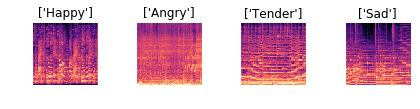

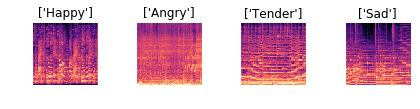

In [11]:

dataset = Dataset(csv_file='./input_label.csv',
                  root_dir='./MelSpectrogram/',
                  tempo_dir='./tempogram/')

fig = plt.figure()
print(len(dataset))

for i in range(len(dataset)):
    sample = dataset[i]

    #print(i, sample['image'].shape, sample['label']) #l was landmarks, changed sample['landmars'].shape to sample['l']
    #print(i, sample['image'], sample['label'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    #ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_melspec(sample['image'], str(sample['label'].values))

    if i == 3:
        plt.show()
        break

In [12]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label, tempo_image = sample['image'], sample['label'], sample['tempo_image']
        

        # The input is a pandas Series
        if isinstance(label, pd.core.series.Series):
            label = label.values[0]
            
        label_id = ["Happy", "Angry", "Tender", "Scary", "Sad", "Funny"].index(label)
        
        #print (label, type(label))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        #TODO: Convert image to RGB
        from PIL import Image
        im = Image.fromarray(image)
        image = np.array(im.convert('RGB'))
        image = image.transpose((2, 0, 1))
        #print (type(image), image.shape)
        image = resize(image, (3, 224, 224))
        #print("After resize",type(image), image.shape)
        

        
        # tempogram 
        im = Image.fromarray(tempo_image)
        tempo_image = np.array(im.convert('RGB'))
        tempo_image = tempo_image.transpose((2, 0, 1))
        tempo_image = resize(tempo_image, (3, 224, 224))
        
        return torch.from_numpy(image), torch.from_numpy(tempo_image), torch.from_numpy(np.array([label_id]))
        
        
        
        #return torch.from_numpy(image), torch.from_numpy(np.array([label_id]))
        
        #return {'image': torch.from_numpy(image),
        #        'label': torch.from_numpy(np.array([label_id]))}

In [13]:
transformed_dataset = Dataset(csv_file='./input_label.csv',
                              root_dir='./MelSpectrogram/',
                              tempo_dir='./tempogram/',
                              transform=ToTensor())

In [14]:
len(transformed_dataset)

10146

10146

In [15]:
valid_size = 0.2
num_train = len(transformed_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

In [16]:
#transformed_dataset[indices]

## https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
## https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

# Shuffle the indices
np.random.seed(123)
np.random.shuffle(indices)

# params
batch_size = 16
num_workers = 1

train_idx, valid_idx = indices[split:], indices[:split]

from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(
        transformed_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(
        transformed_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers)

In [17]:
for i, (images, tempo_images, labels) in enumerate(train_loader):
    print (images.shape, tempo_images.shape, labels.shape) 
    break

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


torch.Size([16, 3, 224, 224]) torch.Size([16, 3, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224]) torch.Size([16, 3, 224, 224]) torch.Size([16, 1])


In [19]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 25
num_classes = 6
batch_size = 64
learning_rate = 0.001

## BUILD THE MODEL

In [20]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        
        self.mels_layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.mels_layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.mels_fc = nn.Linear(32* 56*56, 256)

        self.tempo_layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.tempo_layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
                
        self.tempo_fc = nn.Linear(32* 56*56, 256)
        
        self.fc_out = nn.Linear(512, num_classes)
        
    def forward(self, x):
        
        ## x => 3, 224, 224 
        ## x ==> [B, 6, 224, 224]
        
        mels_out = self.mels_layer1(x[0])
        mels_out = self.mels_layer2(mels_out)
        mels_out = mels_out.reshape(mels_out.size(0), -1)
        mels_out = self.mels_fc(mels_out)
        
        tempo_out = self.tempo_layer1(x[1])
        tempo_out = self.tempo_layer2(tempo_out)
        tempo_out = tempo_out.reshape(tempo_out.size(0), -1)
        tempo_out = self.tempo_fc(tempo_out)     
        
        out = torch.cat((mels_out, tempo_out), 1)
        #print (mels_out.shape, tempo_out.shape, out.shape)
        out = out.reshape(out.size(0), -1)
        #print (out.shape)

        out = self.fc_out(out)
        return out

model = ConvNet(num_classes).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 25
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    total = 0
    correct = 0
    for i, (mels_images, tempo_images, labels) in enumerate(train_loader):
        mels_images = mels_images.float()
        tempo_images = tempo_images.float()
        
        mels_images = mels_images.to(device)
        tempo_images = tempo_images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model([mels_images, tempo_images])
        
        #RuntimeError: multi-target not supported at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/THNN/generic/ClassNLLCriterion.c:21
        # labels.squeeze() would solve the above error. Its because of wrong label shape
        
        loss = criterion(outputs, labels.squeeze())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        _x, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.squeeze() == predicted).sum().item()

        if (i+1) % 100 == 0:
            print (correct, total)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


587 1600
Epoch [1/25], Step [100/508], Loss: 5.4385
587 1600
Epoch [1/25], Step [100/508], Loss: 5.4385
1346 3200
Epoch [1/25], Step [200/508], Loss: 1.0030
1346 3200
Epoch [1/25], Step [200/508], Loss: 1.0030
2149 4800
Epoch [1/25], Step [300/508], Loss: 1.1063
2149 4800
Epoch [1/25], Step [300/508], Loss: 1.1063
3000 6400
Epoch [1/25], Step [400/508], Loss: 1.7589
3000 6400
Epoch [1/25], Step [400/508], Loss: 1.7589
3905 8000
Epoch [1/25], Step [500/508], Loss: 0.8795
3905 8000
Epoch [1/25], Step [500/508], Loss: 0.8795


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


909 1600
Epoch [2/25], Step [100/508], Loss: 0.8870
1814 3200
Epoch [2/25], Step [200/508], Loss: 0.8161
2742 4800
Epoch [2/25], Step [300/508], Loss: 1.1305
3632 6400
Epoch [2/25], Step [400/508], Loss: 1.2985
4498 8000
Epoch [2/25], Step [500/508], Loss: 1.7977


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


954 1600
Epoch [3/25], Step [100/508], Loss: 0.9589
909 1600
Epoch [2/25], Step [100/508], Loss: 0.8870
1814 3200
Epoch [2/25], Step [200/508], Loss: 0.8161
2742 4800
Epoch [2/25], Step [300/508], Loss: 1.1305
3632 6400
Epoch [2/25], Step [400/508], Loss: 1.2985
4498 8000
Epoch [2/25], Step [500/508], Loss: 1.7977


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


954 1600
Epoch [3/25], Step [100/508], Loss: 0.9589
1880 3200
Epoch [3/25], Step [200/508], Loss: 0.9377
1880 3200
Epoch [3/25], Step [200/508], Loss: 0.9377
2786 4800
Epoch [3/25], Step [300/508], Loss: 1.2107
2786 4800
Epoch [3/25], Step [300/508], Loss: 1.2107
3708 6400
Epoch [3/25], Step [400/508], Loss: 0.8031
3708 6400
Epoch [3/25], Step [400/508], Loss: 0.8031
4630 8000
Epoch [3/25], Step [500/508], Loss: 0.9508
4630 8000
Epoch [3/25], Step [500/508], Loss: 0.9508


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


935 1600
Epoch [4/25], Step [100/508], Loss: 0.6205
935 1600
Epoch [4/25], Step [100/508], Loss: 0.6205
1912 3200
Epoch [4/25], Step [200/508], Loss: 0.4445
1912 3200
Epoch [4/25], Step [200/508], Loss: 0.4445
2837 4800
Epoch [4/25], Step [300/508], Loss: 1.2980
2837 4800
Epoch [4/25], Step [300/508], Loss: 1.2980
3803 6400
Epoch [4/25], Step [400/508], Loss: 1.2809
3803 6400
Epoch [4/25], Step [400/508], Loss: 1.2809
4735 8000
Epoch [4/25], Step [500/508], Loss: 0.8589
4735 8000
Epoch [4/25], Step [500/508], Loss: 0.8589


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1047 1600
Epoch [5/25], Step [100/508], Loss: 0.7407
1047 1600
Epoch [5/25], Step [100/508], Loss: 0.7407


In [28]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

all_predictions = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for i, (mels_images, tempo_images, labels) in enumerate(valid_loader):
        mels_images = mels_images.float()
        tempo_images = tempo_images.float()
        
        mels_images = mels_images.to(device)
        tempo_images = tempo_images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model([mels_images, tempo_images])
 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.squeeze() == predicted).sum().item()
        #print (correct, total)
        
        all_predictions.extend(list(predicted.cpu().numpy()))
        all_labels.extend(list(labels.squeeze().cpu().numpy()))
        
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Test Accuracy of the model on the test images: 52.88319369147363 %


In [29]:
# Confusion Matrix
import sklearn
from sklearn.metrics import confusion_matrix
print (sklearn.metrics.confusion_matrix(all_predictions, all_labels))

[[  9   6   5   0   0   4]
 [  1 107   1   1   1   0]
 [116  39 590 101 281  54]
 [  2  12  16 204  15   3]
 [  2   1   9   4  20   0]
 [123  36  96   7  20 143]]


## BUILD the model to avoid OVERFITTING 

In [42]:
class ConvNet_with_dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet_with_dropout, self).__init__()
        
        
        self.mels_layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.mels_layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        
        self.mels_fc = nn.Linear(32* 56*56, 256)
        

        self.tempo_layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.tempo_layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
                
        self.tempo_fc = nn.Linear(32* 56*56, 256)
        
        self.fc_out = nn.Linear(512, num_classes)
        
    def forward(self, x):
        
        ## x => 3, 224, 224 
        ## x ==> [B, 6, 224, 224]
        
        mels_out = self.mels_layer1(x[0])
        mels_out = self.mels_layer2(mels_out)
        mels_out = mels_out.reshape(mels_out.size(0), -1)
        mels_out = self.mels_fc(mels_out)
        
        tempo_out = self.tempo_layer1(x[1])
        tempo_out = self.tempo_layer2(tempo_out)
        tempo_out = tempo_out.reshape(tempo_out.size(0), -1)
        tempo_out = self.tempo_fc(tempo_out)     
        
        out = torch.cat((mels_out, tempo_out), 1)
        #print (mels_out.shape, tempo_out.shape, out.shape)
        out = out.reshape(out.size(0), -1)
        #print (out.shape)

        out = self.fc_out(out)
        return out

model_with_dropout = ConvNet_with_dropout(num_classes).to(device)

In [43]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 5
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    total = 0
    correct = 0
    for i, (mels_images, tempo_images, labels) in enumerate(train_loader):
        mels_images = mels_images.float()
        tempo_images = tempo_images.float()
        
        mels_images = mels_images.to(device)
        tempo_images = tempo_images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_with_dropout([mels_images, tempo_images])
        
        #RuntimeError: multi-target not supported at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/THNN/generic/ClassNLLCriterion.c:21
        # labels.squeeze() would solve the above error. Its because of wrong label shape
        
        loss = criterion(outputs, labels.squeeze())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        _x, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.squeeze() == predicted).sum().item()

        if (i+1) % 100 == 0:
            print (correct, total)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

/Users/Amulya/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/Amulya/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


221 1600
Epoch [1/5], Step [100/508], Loss: 1.9391
411 3200
Epoch [1/5], Step [200/508], Loss: 1.7922
599 4800
Epoch [1/5], Step [300/508], Loss: 1.7232
783 6400
Epoch [1/5], Step [400/508], Loss: 1.6867
985 8000
Epoch [1/5], Step [500/508], Loss: 1.8097


/Users/Amulya/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/Amulya/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


200 1600
Epoch [2/5], Step [100/508], Loss: 1.9150
399 3200
Epoch [2/5], Step [200/508], Loss: 1.7541
589 4800
Epoch [2/5], Step [300/508], Loss: 1.7897


Process Process-20:
Traceback (most recent call last):
  File "/Users/Amulya/anaconda2/envs/py365/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/Amulya/anaconda2/envs/py365/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Amulya/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/Users/Amulya/anaconda2/envs/py365/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/Users/Amulya/anaconda2/envs/py365/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/Users/Amulya/anaconda2/envs/py365/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Users/Amulya/anaconda2/envs/py365/lib/python3.6/multiprocessing/connection.

KeyboardInterrupt: 